In [1]:
# import libraries

# data preprocessing libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# model libraries
from sklearn.ensemble import RandomForestClassifier

# model evaluation libraries
from sklearn.metrics import confusion_matrix, classification_report

## Data Source

https://www.kaggle.com/datasets/rangalamahesh/bank-churn

In [2]:
# import data from csv and convert to dataframe
df = pd.read_csv('raw_data.csv')
df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


## Data Cleaning

In [4]:
# Checking data types
df.dtypes

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object

In [5]:
# Drop unwanted columns
df = df.drop(columns=['CustomerId', 'id', 'Surname'])

# Check columns were dropped
df.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [6]:
# Checking for nulls
df.isnull().sum().sum()

0

In [7]:
# Export as csv for use in Tableau
df.to_csv('cleaned_data.csv', index=False)

## Machine Learning - Pre-processesing

In [8]:
# Look at Target_Churn value counts for balance
classification_counts = df['Exited'].value_counts()
classification_counts

Exited
0    130113
1     34921
Name: count, dtype: int64

In [9]:
# Convert categorical data to numeric with `pd.get_dummies`
df = pd.get_dummies(df)
df.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Exited', 'Geography_France',
       'Geography_Germany', 'Geography_Spain', 'Gender_Female', 'Gender_Male'],
      dtype='object')

In [10]:
# Split our preprocessed data into our features and target arrays
X = df.drop('Exited', axis = "columns")
y = df['Exited']

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [11]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Random Forest with Random Over Sampling

              precision    recall  f1-score   support

        Stay       0.98      0.90      0.94     32493
       Leave       0.91      0.98      0.94     32564

    accuracy                           0.94     65057
   macro avg       0.94      0.94      0.94     65057
weighted avg       0.94      0.94      0.94     65057



<Axes: title={'center': 'Random Forest Features Importances'}, ylabel='Feature'>

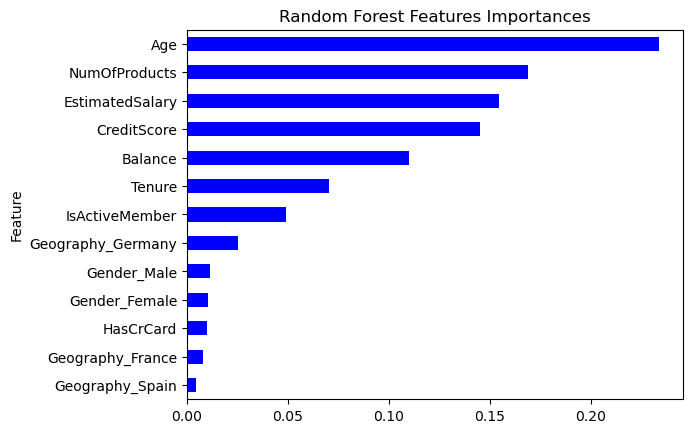

In [13]:
# Prepare data for models using Random Over Sampling

# Split our preprocessed data into our features and target arrays
X = df.drop('Exited', axis = "columns")
y = df['Exited']

# Define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')

# Fit and apply the transform
X_over, y_over = oversample.fit_resample(X, y)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Create a random forest classifier
rf_ros_model = RandomForestClassifier(n_estimators=500, random_state=78)

# Fitting the model
rf_ros_model = rf_ros_model.fit(X_train_scaled, y_train)

# Making predictions using the testing data
predictions = rf_ros_model.predict(X_test_scaled)

# Generate a confusion matrix for the model
confusion_matrix(y_test, predictions)

# Print the classification report for the model
target_names = ["Stay", "Leave"]
print(classification_report(y_test, predictions, target_names=target_names))

# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_ros_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='blue', title= 'Random Forest Features Importances', legend=False, ylabel='Feature')
